# Preprocessing


In [ ]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import PIL.Image
import numpy as np
from typing import Optional, Tuple, List, Dict, Any
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import logging
from pathlib import Path

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)


class JetBotDataset(Dataset):
    """
    Enhanced JetBot dataset with robust preprocessing and data validation.
    Supports multiple augmentation strategies and better error handling.
    """
    
    def __init__(
        self, 
        root_dir: str, 
        transform: Optional[Any] = None,
        target_size: Tuple[int, int] = (224, 224),
        validate_data: bool = True,
        max_samples_per_folder: Optional[int] = None,
        balance_classes: bool = False,
        cache_images: bool = False
    ):
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.target_size = target_size
        self.cache_images = cache_images
        self.image_cache = {} if cache_images else None
        
        # Data containers
        self.samples = []
        self.stats = {'total_samples': 0, 'folders_processed': 0, 'errors': 0}
        
        # Load and validate data
        self._load_data(max_samples_per_folder, validate_data)
        
        if balance_classes:
            self._balance_dataset()
            
        logger.info(f"Dataset initialized with {len(self.samples)} samples")
        self._print_stats()
    
    def _load_data(self, max_samples_per_folder: Optional[int], validate_data: bool):
        """Load data from all folders with improved error handling"""
        if not self.root_dir.exists():
            raise FileNotFoundError(f"Root directory {self.root_dir} not found")
        
        folders = [d for d in self.root_dir.iterdir() if d.is_dir()]
        
        for folder in folders:
            try:
                self._process_folder(folder, max_samples_per_folder, validate_data)
                self.stats['folders_processed'] += 1
            except Exception as e:
                logger.error(f"Error processing folder {folder.name}: {e}")
                self.stats['errors'] += 1
    
    def _process_folder(self, folder: Path, max_samples: Optional[int], validate_data: bool):
        """Process a single folder"""
        csv_file = self.root_dir / f"{folder.name}.csv"
        
        if not csv_file.exists():
            logger.warning(f"CSV file {csv_file} not found, skipping folder {folder.name}")
            return
        
        try:
            # Read CSV with better error handling
            df = pd.read_csv(
                csv_file, 
                header=None, 
                dtype={0: "str", 1: "float32", 2: "float32"},
                na_values=['', 'nan', 'NaN']
            )
            df.columns = ["filename", "forward", "left"]
            
            # Remove rows with NaN values
            df = df.dropna()
            
            # Limit samples if specified
            if max_samples and len(df) > max_samples:
                df = df.sample(n=max_samples, random_state=42)
            
            folder_samples = []
            for _, row in df.iterrows():
                sample = self._process_sample(folder, row, validate_data)
                if sample:
                    folder_samples.append(sample)
            
            self.samples.extend(folder_samples)
            self.stats['total_samples'] += len(folder_samples)
            logger.info(f"Loaded {len(folder_samples)} samples from {folder.name}")
            
        except Exception as e:
            logger.error(f"Error reading CSV {csv_file}: {e}")
            raise
    
    def _process_sample(self, folder: Path, row: pd.Series, validate_data: bool) -> Optional[Tuple]:
        """Process a single sample with validation"""
        try:
            # Handle filename formatting
            filename = str(row['filename']).strip()
            if filename.endswith('.0'):
                filename = filename[:-2]
            
            # Create image path
            img_path = folder / f"{filename.zfill(4)}.jpg"
            
            if not img_path.exists():
                logger.warning(f"Image file {img_path} not found")
                return None
            
            forward, left = float(row["forward"]), float(row["left"])
            
            # Validate control values
            if validate_data and not self._validate_controls(forward, left):
                logger.warning(f"Invalid control values: forward={forward}, left={left}")
                return None
            
            return (str(img_path), forward, left)
            
        except Exception as e:
            logger.error(f"Error processing sample: {e}")
            return None
    
    def _validate_controls(self, forward: float, left: float) -> bool:
        """Validate control values are within reasonable ranges"""
        return (
            -1.5 <= forward <= 1.5 and 
            -1.5 <= left <= 1.5 and
            not (np.isnan(forward) or np.isnan(left))
        )
    
    def _balance_dataset(self):
        """Balance dataset by control value distributions"""
        if len(self.samples) == 0:
            logger.warning("No samples to balance")
            return
            
        # Simple binning approach for balancing
        forward_bins = np.linspace(-1, 1, 10)
        left_bins = np.linspace(-1, 1, 10)
        
        binned_samples = {}
        for sample in self.samples:
            forward_bin = np.digitize(sample[1], forward_bins)
            left_bin = np.digitize(sample[2], left_bins)
            key = (forward_bin, left_bin)
            
            if key not in binned_samples:
                binned_samples[key] = []
            binned_samples[key].append(sample)
        
        # Remove empty bins and find minimum bin size
        binned_samples = {k: v for k, v in binned_samples.items() if len(v) > 0}
        if not binned_samples:
            logger.warning("No valid bins for balancing")
            return
            
        min_size = min(len(samples) for samples in binned_samples.values())
        if min_size == 0:
            logger.warning("Minimum bin size is 0, skipping balancing")
            return
            
        balanced_samples = []
        
        for samples in binned_samples.values():
            if len(samples) >= min_size:
                # Convert to numpy array of indices, then select samples
                indices = np.random.choice(len(samples), min_size, replace=False)
                selected_samples = [samples[i] for i in indices]
                balanced_samples.extend(selected_samples)
            else:
                balanced_samples.extend(samples)
        
        self.samples = balanced_samples
        logger.info(f"Balanced dataset to {len(self.samples)} samples")
    
    def _print_stats(self):
        """Print dataset statistics"""
        if not self.samples:
            return
        
        forwards = [s[1] for s in self.samples]
        lefts = [s[2] for s in self.samples]
        
        logger.info(f"""
        Dataset Statistics:
        - Total samples: {len(self.samples)}
        - Folders processed: {self.stats['folders_processed']}
        - Processing errors: {self.stats['errors']}
        - Forward range: [{min(forwards):.3f}, {max(forwards):.3f}]
        - Left range: [{min(lefts):.3f}, {max(lefts):.3f}]
        - Forward mean±std: {np.mean(forwards):.3f}±{np.std(forwards):.3f}
        - Left mean±std: {np.mean(lefts):.3f}±{np.std(lefts):.3f}
        """)
    
    def __len__(self) -> int:
        return len(self.samples)
    
    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        img_path, forward, left = self.samples[idx]
        
        try:
            # Load image with caching support
            if self.cache_images and img_path in self.image_cache:
                image = self.image_cache[img_path]
            else:
                image = self._load_image(img_path)
                if self.cache_images:
                    self.image_cache[img_path] = image.copy()
            
            # Apply transformations
            if self.transform:
                try:
                    # Handle albumentations transforms
                    if hasattr(self.transform, 'processors') or 'albumentations' in str(type(self.transform)):
                        if isinstance(image, np.ndarray):
                            transformed = self.transform(image=image)
                            image = transformed['image']
                        else:
                            # Convert PIL to numpy for albumentations
                            if hasattr(image, 'convert'):
                                image = np.array(image.convert('RGB'))
                            transformed = self.transform(image=image)
                            image = transformed['image']
                    else:
                        # Handle torchvision transforms
                        if isinstance(image, np.ndarray):
                            image = PIL.Image.fromarray(image)
                        image = self.transform(image)
                except Exception as transform_error:
                    logger.error(f"Transform error for {img_path}: {transform_error}")
                    # Fall back to basic resize and normalize
                    if isinstance(image, np.ndarray):
                        image = cv2.resize(image, self.target_size)
                        image = image.astype(np.float32) / 255.0
                        image = torch.from_numpy(image).permute(2, 0, 1)
                    else:
                        image = image.resize(self.target_size)
                        image = transforms.ToTensor()(image)
            
            # Ensure image is a tensor with correct shape
            if not isinstance(image, torch.Tensor):
                if isinstance(image, np.ndarray):
                    if image.ndim == 3 and image.shape[2] == 3:  # HWC format
                        image = torch.from_numpy(image).permute(2, 0, 1).float()
                    else:
                        image = torch.from_numpy(image).float()
                else:
                    image = transforms.ToTensor()(image)
            
            # Validate tensor shape
            if image.shape[0] != 3 or len(image.shape) != 3:
                raise ValueError(f"Invalid image shape: {image.shape}")
            
            return image, torch.tensor([forward, left], dtype=torch.float32)
            
        except Exception as e:
            logger.error(f"Error loading sample {idx} ({img_path}): {e}")
            # Return placeholder with correct shape
            placeholder = torch.zeros((3, *self.target_size), dtype=torch.float32)
            return placeholder, torch.tensor([0.0, 0.0], dtype=torch.float32)
    
    def _load_image(self, img_path: str) -> np.ndarray:
        """Load and preprocess image"""
        # Use OpenCV for faster loading
        image = cv2.imread(img_path)
        if image is None:
            raise ValueError(f"Could not load image: {img_path}")
        
        # Convert BGR to RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image


class AdvancedTransforms:
    """Advanced transformation pipeline with multiple strategies"""
    
    @staticmethod
    def get_albumentations_transforms(
        target_size: Tuple[int, int] = (224, 224),
        augment: bool = True,
        augment_strength: str = 'medium'
    ) -> A.Compose:
        """Get albumentations-based transforms (recommended for better performance)"""
        
        base_transforms = [
            A.Resize(target_size[0], target_size[1]),
            A.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225]
            ),
            ToTensorV2()
        ]
        
        if not augment:
            return A.Compose(base_transforms)
        
        # Define augmentation strengths
        aug_configs = {
            'light': {
                'brightness_limit': 0.1,
                'contrast_limit': 0.1,
                'blur_limit': 3,
                'rotation_limit': 1,
                'p': 0.3
            },
            'medium': {
                'brightness_limit': 0.2,
                'contrast_limit': 0.2,
                'blur_limit': 5,
                'rotation_limit': 3,
                'p': 0.5
            },
            'strong': {
                'brightness_limit': 0.3,
                'contrast_limit': 0.3,
                'blur_limit': 7,
                'rotation_limit': 5,
                'p': 0.7
            }
        }
        
        config = aug_configs.get(augment_strength, aug_configs['strong'])
        
        augment_transforms = [
            # Color augmentations
            A.RandomBrightnessContrast(
                brightness_limit=config['brightness_limit'],
                contrast_limit=config['contrast_limit'],
                p=config['p']
            ),
            A.HueSaturationValue(
                hue_shift_limit=10,
                sat_shift_limit=20,
                val_shift_limit=10,
                p=config['p']
            ),
            
            # Geometric augmentations (careful with robot navigation!)
            A.Rotate(
                limit=config['rotation_limit'],
                border_mode=cv2.BORDER_CONSTANT,
                value=0,
                p=config['p']
            ),
            A.ShiftScaleRotate(
                shift_limit=0.05,
                scale_limit=0.1,
                rotate_limit=config['rotation_limit'],
                border_mode=cv2.BORDER_CONSTANT,
                value=0,
                p=config['p']
            ),
            
            # Noise and blur
            A.GaussianBlur(
                blur_limit=(3, config['blur_limit']),
                p=config['p']
            ),
            A.GaussNoise(
                var_limit=(5.0, 30.0),
                p=config['p'] * 0.5
            ),
            
            *base_transforms
        ]
        
        return A.Compose(augment_transforms)
    

def create_dataloaders(
    root_dir: str,
    batch_size: int = 32,
    train_split: float = 0.7,
    val_split: float = 0.2,
    test_split: float = 0.1,
    target_size: Tuple[int, int] = (224, 224),
    use_albumentations: bool = True,
    augment_strength: str = 'strong',
    num_workers: int = 0,  # Set to 0 to avoid multiprocessing issues
    include_test: bool = True,
    **dataset_kwargs
) -> Tuple[DataLoader, ...]:
    """Create train, validation, and optionally test dataloaders
    
    Args:
        root_dir: Path to dataset root directory
        batch_size: Batch size for dataloaders
        train_split: Fraction of data for training (default: 0.7)
        val_split: Fraction of data for validation (default: 0.2) 
        test_split: Fraction of data for testing (default: 0.1)
        include_test: Whether to create test split (default: True)
        **other args: Additional arguments
    
    Returns:
        If include_test=True: (train_loader, val_loader, test_loader)
        If include_test=False: (train_loader, val_loader)
    """
    
    # Validate splits
    if include_test:
        total_split = train_split + val_split + test_split
        if abs(total_split - 1.0) > 1e-6:
            raise ValueError(f"Splits must sum to 1.0, got {total_split}")
    else:
        total_split = train_split + val_split
        if abs(total_split - 1.0) > 1e-6:
            # Auto-adjust if only train/val specified
            train_split = train_split / total_split
            val_split = val_split / total_split
            logger.info(f"Adjusted splits: train={train_split:.3f}, val={val_split:.3f}")
    
    # Create transforms
    if use_albumentations:
        try:
            train_transform = AdvancedTransforms.get_albumentations_transforms(
                target_size=target_size,
                augment=True,
                augment_strength=augment_strength
            )
            val_transform = AdvancedTransforms.get_albumentations_transforms(
                target_size=target_size,
                augment=False
            )
            test_transform = val_transform  # Same as validation
        except ImportError:
            logger.warning("Albumentations not available, falling back to torchvision")
            use_albumentations = False
    
    # Create full dataset
    full_dataset = JetBotDataset(
        root_dir=root_dir,
        target_size=target_size,
        **dataset_kwargs
    )
    
    if len(full_dataset) == 0:
        raise ValueError("Dataset is empty. Check your data path and CSV files.")
    
    # Split dataset
    total_size = len(full_dataset)
    
    if include_test:
        train_size = int(train_split * total_size)
        val_size = int(val_split * total_size)
        test_size = total_size - train_size - val_size
        
        if train_size == 0 or val_size == 0 or test_size == 0:
            logger.warning(f"Very small dataset: train={train_size}, val={val_size}, test={test_size}")
            # Fall back to using the same dataset
            train_dataset = val_dataset = test_dataset = full_dataset
        else:
            train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
                full_dataset, 
                [train_size, val_size, test_size],
                generator=torch.Generator().manual_seed(42)
            )
    else:
        train_size = int(train_split * total_size)
        val_size = total_size - train_size
        
        if train_size == 0 or val_size == 0:
            logger.warning(f"Very small dataset: train={train_size}, val={val_size}")
            train_dataset = val_dataset = full_dataset
        else:
            train_dataset, val_dataset = torch.utils.data.random_split(
                full_dataset, 
                [train_size, val_size],
                generator=torch.Generator().manual_seed(42)
            )
    
    # Create separate dataset instances with transforms
    datasets_to_create = ['train', 'val']
    if include_test:
        datasets_to_create.append('test')
    
    created_datasets = {}
    
    for split_name in datasets_to_create:
        # Choose appropriate transform
        if split_name == 'train':
            transform = train_transform
            original_dataset = train_dataset
        elif split_name == 'val':
            transform = val_transform
            original_dataset = val_dataset
        else:  # test
            transform = test_transform
            original_dataset = test_dataset
        
        # Create dataset copy with transform
        if hasattr(original_dataset, 'dataset'):
            # Handle Subset case
            dataset_copy = JetBotDataset(
                root_dir=root_dir,
                target_size=target_size,
                transform=transform,
                **dataset_kwargs
            )
            # Apply subset indices
            dataset_copy.samples = [full_dataset.samples[i] for i in original_dataset.indices]
        else:
            # Apply transform directly
            dataset_copy = original_dataset
            dataset_copy.transform = transform
        
        created_datasets[split_name] = dataset_copy
    
    # Create dataloaders with safer settings
    train_loader = DataLoader(
        created_datasets['train'],
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=False,  # Disable pin_memory to avoid issues
        drop_last=True,
        persistent_workers=False,
        timeout=30 if num_workers > 0 else 0
    )
    
    val_loader = DataLoader(
        created_datasets['val'],
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=False,  # Disable pin_memory to avoid issues
        drop_last=False,
        persistent_workers=False,
        timeout=30 if num_workers > 0 else 0
    )
    
    if include_test:
        test_loader = DataLoader(
            created_datasets['test'],
            batch_size=batch_size,
            shuffle=False,  # Never shuffle test set
            num_workers=num_workers,
            pin_memory=False,
            drop_last=False,
            persistent_workers=False,
            timeout=30 if num_workers > 0 else 0
        )
        
        logger.info(f"Created dataloaders: train={len(train_loader)}, val={len(val_loader)}, test={len(test_loader)} batches")
        return train_loader, val_loader, test_loader
    else:
        logger.info(f"Created dataloaders: train={len(train_loader)}, val={len(val_loader)} batches")
        return train_loader, val_loader


# Example usage
if __name__ == "__main__":
    try:
        dataset = JetBotDataset(
            root_dir="../put_jetbot_dataset/dataset/",
            validate_data=True,
            balance_classes=True  
        )
        
        print(f"Dataset loaded with {len(dataset)} samples")
        
        # Test single sample loading
        if len(dataset) > 0:
            sample_img, sample_controls = dataset[0]
            print(f"Sample image shape: {sample_img.shape}")
            print(f"Sample controls: {sample_controls}")
        
        # Three-way split (train/val/test)
        print("\n=== Creating train/val/test split ===")
        train_loader, val_loader, test_loader = create_dataloaders(
            root_dir="../put_jetbot_dataset/dataset/",
            batch_size=8,
            train_split=0.7,  # 70% for training
            val_split=0.2,    # 20% for validation
            test_split=0.1,   # 10% for testing
            use_albumentations=True,
            validate_data=True,
            balance_classes=False,
            num_workers=0,
            include_test=True
        )
        
        print(f"Train batches: {len(train_loader)}")
        print(f"Val batches: {len(val_loader)}")
        print(f"Test batches: {len(test_loader)}")
        
        # # Example 2: Two-way split (train/val only)
        # print("\n=== Creating train/val split only ===")
        # train_loader2, val_loader2 = create_dataloaders(
        #     root_dir="../put_jetbot_dataset/dataset/",
        #     batch_size=8,
        #     train_split=0.8,  # 80% for training
        #     val_split=0.2,    # 20% for validation
        #     use_albumentations=False,
        #     validate_data=True,
        #     balance_classes=False,
        #     num_workers=0,
        #     include_test=False
        # )
        
        # print(f"Train batches: {len(train_loader2)}")
        # print(f"Val batches: {len(val_loader2)}")
        
        # Test loading batches from all splits
        print("\n=== Testing batch loading ===")
        
        # Test train batch
        for images, controls in train_loader:
            print(f"Train batch - Images: {images.shape}, Controls: {controls.shape}")
            break
        
        # Test val batch  
        for images, controls in val_loader:
            print(f"Val batch - Images: {images.shape}, Controls: {controls.shape}")
            break
            
        # Test test batch
        for images, controls in test_loader:
            print(f"Test batch - Images: {images.shape}, Controls: {controls.shape}")
            break
        
    except Exception as e:
        logger.error(f"Error in example usage: {e}")
        import traceback
        traceback.print_exc()

INFO:__main__:Loaded 182 samples from 1652875851.3497071
INFO:__main__:Loaded 708 samples from 1652875901.3107166
INFO:__main__:Loaded 660 samples from 1652876013.741493
INFO:__main__:Loaded 891 samples from 1652876206.2541456
INFO:__main__:Loaded 995 samples from 1652876485.8123376
INFO:__main__:Loaded 805 samples from 1652959186.4507334
INFO:__main__:Loaded 633 samples from 1652959347.972946
INFO:__main__:Loaded 435 samples from 1653042695.4914637
INFO:__main__:Loaded 391 samples from 1653042775.5213027
INFO:__main__:Loaded 609 samples from 1653043202.5073502
INFO:__main__:Loaded 532 samples from 1653043345.3415065
INFO:__main__:Loaded 670 samples from 1653043428.8546412
INFO:__main__:Loaded 73 samples from 1653043549.5187616
INFO:__main__:Balanced dataset to 46 samples
INFO:__main__:Dataset initialized with 46 samples
INFO:__main__:
        Dataset Statistics:
        - Total samples: 46
        - Folders processed: 13
        - Processing errors: 0
        - Forward range: [-0.992,

Dataset loaded with 46 samples
Sample image shape: torch.Size([3, 224, 224])
Sample controls: tensor([0., 0.])

=== Creating train/val/test split ===


INFO:__main__:Loaded 708 samples from 1652875901.3107166
INFO:__main__:Loaded 660 samples from 1652876013.741493
INFO:__main__:Loaded 891 samples from 1652876206.2541456
INFO:__main__:Loaded 995 samples from 1652876485.8123376
INFO:__main__:Loaded 805 samples from 1652959186.4507334
INFO:__main__:Loaded 633 samples from 1652959347.972946
INFO:__main__:Loaded 435 samples from 1653042695.4914637
INFO:__main__:Loaded 391 samples from 1653042775.5213027
INFO:__main__:Loaded 609 samples from 1653043202.5073502
INFO:__main__:Loaded 532 samples from 1653043345.3415065
INFO:__main__:Loaded 670 samples from 1653043428.8546412
INFO:__main__:Loaded 73 samples from 1653043549.5187616
INFO:__main__:Dataset initialized with 7584 samples
INFO:__main__:
        Dataset Statistics:
        - Total samples: 7584
        - Folders processed: 13
        - Processing errors: 0
        - Forward range: [-0.992, 1.000]
        - Left range: [-1.000, 0.992]
        - Forward mean±std: 0.869±0.212
        - Le

Train batches: 663
Val batches: 190
Test batches: 95

=== Testing batch loading ===
Train batch - Images: torch.Size([8, 3, 224, 224]), Controls: torch.Size([8, 2])
Val batch - Images: torch.Size([8, 3, 224, 224]), Controls: torch.Size([8, 2])
Test batch - Images: torch.Size([8, 3, 224, 224]), Controls: torch.Size([8, 2])


# Model

In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np
from typing import List, Tuple, Dict, Optional
import logging
from pathlib import Path
from collections import defaultdict
import time
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import seaborn as sns

In [33]:
# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [34]:
# Set plot style
plt.style.use('seaborn-v0_8' if 'seaborn-v0_8' in plt.style.available else 'default')
sns.set_palette("husl")

In [35]:
def visualize_batch(dataloader, num_samples: int = 8, save_path: Optional[str] = None):
    """
    Visualize a batch of training images with their control values
    """
    # Get one batch
    images, controls = next(iter(dataloader))
    
    # Limit number of samples to display
    num_samples = min(num_samples, len(images))
    
    # Create subplot grid
    cols = 4
    rows = (num_samples + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(15, 4*rows))
    if rows == 1:
        axes = [axes] if cols == 1 else axes
    else:
        axes = axes.flatten()
    
    for i in range(num_samples):
        img = images[i]
        forward, left = controls[i]
        
        # Convert tensor to numpy and transpose for plotting (CHW -> HWC)
        if img.shape[0] == 3:  # RGB image
            img_np = img.permute(1, 2, 0).cpu().numpy()
            
            # Denormalize if normalized (assuming ImageNet normalization)
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            img_np = img_np * std + mean
            img_np = np.clip(img_np, 0, 1)
        else:
            img_np = img.squeeze().cpu().numpy()
        
        axes[i].imshow(img_np)
        axes[i].set_title(f'Forward: {forward:.3f}\nLeft: {left:.3f}')
        axes[i].axis('off')
    
    # Hide unused subplots
    for i in range(num_samples, len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.suptitle('Training Batch Visualization', fontsize=16, y=1.02)
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        logger.info(f"Batch visualization saved to {save_path}")
    
    plt.show()

In [36]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# from typing import Tuple

class JetBotNet(nn.Module):
    """
    JetBot control prediction network based on NVIDIA's end-to-end architecture with regularization
    """
    
    def __init__(
        self, 
        input_size: Tuple[int, int] = (224, 224),
        dropout_rate: float = 0.3,
        use_batch_norm: bool = True
    ):
        super(JetBotNet, self).__init__()
        
        self.input_size = input_size
        self.dropout_rate = dropout_rate
        self.use_batch_norm = use_batch_norm
        
        # Convolutional layers following NVIDIA architecture pattern
        self.conv1a = nn.Conv2d(3, 12, kernel_size=3, stride=2, padding=1)
        self.bn1a = nn.BatchNorm2d(12) if use_batch_norm else nn.Identity()
        self.conv1b = nn.Conv2d(12, 12, kernel_size=3, stride=1, padding=1)
        self.bn1b = nn.BatchNorm2d(12) if use_batch_norm else nn.Identity()
        self.dropout1 = nn.Dropout2d(p=dropout_rate * 0.5)
        
        self.conv2a = nn.Conv2d(12, 18, kernel_size=3, stride=2, padding=1)
        self.bn2a = nn.BatchNorm2d(18) if use_batch_norm else nn.Identity()
        self.conv2b = nn.Conv2d(18, 18, kernel_size=3, stride=1, padding=1)
        self.bn2b = nn.BatchNorm2d(18) if use_batch_norm else nn.Identity()
        self.dropout2 = nn.Dropout2d(p=dropout_rate * 0.5)
        
        self.conv3a = nn.Conv2d(18, 24, kernel_size=3, stride=2, padding=1)
        self.bn3a = nn.BatchNorm2d(24) if use_batch_norm else nn.Identity()
        self.conv3b = nn.Conv2d(24, 24, kernel_size=3, stride=1, padding=1)
        self.bn3b = nn.BatchNorm2d(24) if use_batch_norm else nn.Identity()
        self.dropout3 = nn.Dropout2d(p=dropout_rate * 0.5)
        
        self.conv4 = nn.Conv2d(24, 32, kernel_size=3, stride=2, padding=1)
        self.bn4 = nn.BatchNorm2d(32) if use_batch_norm else nn.Identity()
        self.conv5 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(32) if use_batch_norm else nn.Identity()
        self.dropout4 = nn.Dropout2d(p=dropout_rate * 0.5)
        
        # Calculate feature size dynamically
        with torch.no_grad():
            dummy_input = torch.randn(1, 3, *input_size)
            conv_output = self._forward_conv_layers(dummy_input)
            feature_size = conv_output.numel()
        
        # Fully connected layers with regularization
        self.fc1 = nn.Linear(feature_size, 64)
        self.dropout_fc1 = nn.Dropout(p=dropout_rate)
        
        self.fc2 = nn.Linear(64, 32)
        self.dropout_fc2 = nn.Dropout(p=dropout_rate)
        
        self.fc3 = nn.Linear(32, 10)
        self.dropout_fc3 = nn.Dropout(p=dropout_rate * 0.5)
        
        self.output = nn.Linear(10, 2)  # Output: [forward, left]
        
        # Initialize weights
        self._initialize_weights()
    
    def _forward_conv_layers(self, x):
        """Helper method to forward through conv layers only"""
        x = F.relu(self.bn1a(self.conv1a(x)))
        x = F.relu(self.bn1b(self.conv1b(x)))
        x = self.dropout1(x)
        
        x = F.relu(self.bn2a(self.conv2a(x)))
        x = F.relu(self.bn2b(self.conv2b(x)))
        x = self.dropout2(x)
        
        x = F.relu(self.bn3a(self.conv3a(x)))
        x = F.relu(self.bn3b(self.conv3b(x)))
        x = self.dropout3(x)
        
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.bn5(self.conv5(x)))
        x = self.dropout4(x)
        
        return x
    
    def _initialize_weights(self):
        """Initialize model weights using Xavier/He initialization"""
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Forward through convolutional layers
        x = self._forward_conv_layers(x)
        
        # Flatten for fully connected layers
        x = x.view(x.size(0), -1)
        
        # Forward through fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout_fc1(x)
        
        x = F.relu(self.fc2(x))
        x = self.dropout_fc2(x)
        
        x = F.relu(self.fc3(x))
        x = self.dropout_fc3(x)
        
        x = self.output(x)
        
        return x

In [37]:
class EarlyStopping:
    """Early stopping utility class"""
    
    def __init__(
        self, 
        patience: int = 10, 
        min_delta: float = 1e-4, 
        restore_best_weights: bool = True
    ):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_loss = None
        self.counter = 0
        self.best_weights = None
        
    def __call__(self, val_loss: float, model: nn.Module) -> bool:
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(model)
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.save_checkpoint(model)
        else:
            self.counter += 1
            
        if self.counter >= self.patience:
            if self.restore_best_weights:
                model.load_state_dict(self.best_weights)
            return True
        return False
    
    def save_checkpoint(self, model: nn.Module):
        """Save model weights"""
        self.best_weights = model.state_dict().copy()

# Training

In [38]:
class JetBotTrainer:
    """Training pipeline for JetBot model"""
    
    def __init__(
        self,
        model: nn.Module,
        device: torch.device,
        learning_rate: float = 1e-3,
        weight_decay: float = 1e-4,
        scheduler_patience: int = 5,
        scheduler_factor: float = 0.5
    ):
        self.model = model.to(device)
        self.device = device
        
        # Loss function - MSE for regression
        self.criterion = nn.MSELoss()
        
        # Optimizer - Adam with weight decay
        self.optimizer = optim.Adam(
            self.model.parameters(),
            lr=learning_rate,
            weight_decay=weight_decay,
            betas=(0.9, 0.999),
            eps=1e-8
        )
        
        # Learning rate scheduler
        self.scheduler = ReduceLROnPlateau(
            self.optimizer,
            mode='min',
            factor=scheduler_factor,
            patience=scheduler_patience,
            verbose=True,
            min_lr=1e-6
        )
        
        # Training history
        self.history = defaultdict(list)
        
    def train_epoch(self, train_loader) -> Dict[str, float]:
        """Train for one epoch"""
        self.model.train()
        total_loss = 0.0
        num_batches = 0
        
        for batch_idx, (images, targets) in enumerate(train_loader):
            images, targets = images.to(self.device), targets.to(self.device)
            
            # Forward pass
            self.optimizer.zero_grad()
            outputs = self.model(images)
            loss = self.criterion(outputs, targets)
            
            # Backward pass
            loss.backward()
            
            # Gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            
            self.optimizer.step()
            
            total_loss += loss.item()
            num_batches += 1
            
            # Log progress
            if batch_idx % 50 == 0:
                logger.info(f'Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.6f}')
        
        avg_loss = total_loss / num_batches
        return {'loss': avg_loss}
    
    def validate_epoch(self, val_loader) -> Dict[str, float]:
        """Validate for one epoch"""
        self.model.eval()
        total_loss = 0.0
        all_predictions = []
        all_targets = []
        num_batches = 0
        
        with torch.no_grad():
            for images, targets in val_loader:
                images, targets = images.to(self.device), targets.to(self.device)
                
                outputs = self.model(images)
                loss = self.criterion(outputs, targets)
                
                total_loss += loss.item()
                num_batches += 1
                
                # Store predictions for metrics
                all_predictions.append(outputs.cpu().numpy())
                all_targets.append(targets.cpu().numpy())
        
        # Calculate metrics
        predictions = np.vstack(all_predictions)
        targets = np.vstack(all_targets)
        
        mse = mean_squared_error(targets, predictions)
        mae = mean_absolute_error(targets, predictions)
        
        # R² score for each output
        r2_forward = r2_score(targets[:, 0], predictions[:, 0])
        r2_left = r2_score(targets[:, 1], predictions[:, 1])
        
        return {
            'loss': total_loss / num_batches,
            'mse': mse,
            'mae': mae,
            'r2_forward': r2_forward,
            'r2_left': r2_left
        }
    
    def train(
        self,
        train_loader,
        val_loader,
        epochs: int = 100,
        early_stopping_patience: int = 15,
        save_best_model: bool = True,
        model_save_path: str = 'best_jetbot_model.pth'
    ):
        """Full training loop with early stopping"""
        
        early_stopping = EarlyStopping(
            patience=early_stopping_patience,
            min_delta=1e-5,
            restore_best_weights=True
        )
        
        best_val_loss = float('inf')
        start_time = time.time()
        
        logger.info(f"Starting training for {epochs} epochs...")
        logger.info(f"Device: {self.device}")
        logger.info(f"Model parameters: {sum(p.numel() for p in self.model.parameters()):,}")
        
        for epoch in range(epochs):
            epoch_start = time.time()
            
            # Training phase
            train_metrics = self.train_epoch(train_loader)
            
            # Validation phase
            val_metrics = self.validate_epoch(val_loader)
            
            # Update learning rate
            self.scheduler.step(val_metrics['loss'])
            
            # Store metrics
            self.history['train_loss'].append(train_metrics['loss'])
            self.history['val_loss'].append(val_metrics['loss'])
            self.history['val_mse'].append(val_metrics['mse'])
            self.history['val_mae'].append(val_metrics['mae'])
            self.history['val_r2_forward'].append(val_metrics['r2_forward'])
            self.history['val_r2_left'].append(val_metrics['r2_left'])
            self.history['lr'].append(self.optimizer.param_groups[0]['lr'])
            
            # Save best model
            if val_metrics['loss'] < best_val_loss:
                best_val_loss = val_metrics['loss']
                if save_best_model:
                    torch.save({
                        'epoch': epoch,
                        'model_state_dict': self.model.state_dict(),
                        'optimizer_state_dict': self.optimizer.state_dict(),
                        'scheduler_state_dict': self.scheduler.state_dict(),
                        'val_loss': val_metrics['loss'],
                        'history': dict(self.history)
                    }, model_save_path)
            
            epoch_time = time.time() - epoch_start
            
            # Log epoch results
            logger.info(
                f"Epoch {epoch+1}/{epochs} ({epoch_time:.1f}s) - "
                f"Train Loss: {train_metrics['loss']:.6f}, "
                f"Val Loss: {val_metrics['loss']:.6f}, "
                f"Val MAE: {val_metrics['mae']:.4f}, "
                f"Val R² (F/L): {val_metrics['r2_forward']:.3f}/{val_metrics['r2_left']:.3f}, "
                f"LR: {self.optimizer.param_groups[0]['lr']:.2e}"
            )
            
            # Early stopping check
            if early_stopping(val_metrics['loss'], self.model):
                logger.info(f"Early stopping triggered at epoch {epoch+1}")
                break
        
        total_time = time.time() - start_time
        logger.info(f"Training completed in {total_time:.1f}s")
        
        return dict(self.history)

In [39]:
def plot_training_curves(history: Dict[str, List], save_path: Optional[str] = None):
    """Plot training convergence curves"""
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    # Loss curves
    axes[0, 0].plot(history['train_loss'], label='Train Loss', linewidth=2)
    axes[0, 0].plot(history['val_loss'], label='Validation Loss', linewidth=2)
    axes[0, 0].set_title('Training & Validation Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('MSE Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # MAE
    axes[0, 1].plot(history['val_mae'], label='Validation MAE', color='orange', linewidth=2)
    axes[0, 1].set_title('Mean Absolute Error')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('MAE')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # R² scores
    axes[0, 2].plot(history['val_r2_forward'], label='Forward R²', linewidth=2)
    axes[0, 2].plot(history['val_r2_left'], label='Left R²', linewidth=2)
    axes[0, 2].set_title('R² Score (Coefficient of Determination)')
    axes[0, 2].set_xlabel('Epoch')
    axes[0, 2].set_ylabel('R² Score')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)
    
    # Learning rate
    axes[1, 0].plot(history['lr'], color='red', linewidth=2)
    axes[1, 0].set_title('Learning Rate Schedule')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Learning Rate')
    axes[1, 0].set_yscale('log')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Loss comparison (log scale)
    axes[1, 1].semilogy(history['train_loss'], label='Train Loss', linewidth=2)
    axes[1, 1].semilogy(history['val_loss'], label='Validation Loss', linewidth=2)
    axes[1, 1].set_title('Loss Curves (Log Scale)')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('MSE Loss (log)')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    # Training summary text
    axes[1, 2].axis('off')
    final_train_loss = history['train_loss'][-1]
    final_val_loss = history['val_loss'][-1]
    final_mae = history['val_mae'][-1]
    final_r2_forward = history['val_r2_forward'][-1]
    final_r2_left = history['val_r2_left'][-1]
    
    summary_text = f"""Final Training Results:
    
Train Loss: {final_train_loss:.6f}
Val Loss: {final_val_loss:.6f}
Val MAE: {final_mae:.4f}

R² Scores:
Forward: {final_r2_forward:.3f}
Left: {final_r2_left:.3f}

Total Epochs: {len(history['train_loss'])}"""
    
    axes[1, 2].text(0.1, 0.5, summary_text, fontsize=12, verticalalignment='center',
                    bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgray", alpha=0.8))
    
    plt.tight_layout()
    plt.suptitle('JetBot Model Training Convergence', fontsize=16, y=1.02)
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        logger.info(f"Training curves saved to {save_path}")
    
    plt.show()


In [40]:
def evaluate_model(
    model: nn.Module, 
    test_loader, 
    device: torch.device,
    save_path: Optional[str] = None
) -> Dict[str, float]:
    """Comprehensive model evaluation"""
    
    model.eval()
    all_predictions = []
    all_targets = []
    
    logger.info("Running final model evaluation...")
    
    with torch.no_grad():
        for images, targets in test_loader:
            images, targets = images.to(device), targets.to(device)
            outputs = model(images)
            
            all_predictions.append(outputs.cpu().numpy())
            all_targets.append(targets.cpu().numpy())
    
    predictions = np.vstack(all_predictions)
    targets = np.vstack(all_targets)
    
    # Calculate comprehensive metrics
    mse = mean_squared_error(targets, predictions)
    mae = mean_absolute_error(targets, predictions)
    rmse = np.sqrt(mse)
    
    # Per-output metrics
    mse_forward = mean_squared_error(targets[:, 0], predictions[:, 0])
    mse_left = mean_squared_error(targets[:, 1], predictions[:, 1])
    mae_forward = mean_absolute_error(targets[:, 0], predictions[:, 0])
    mae_left = mean_absolute_error(targets[:, 1], predictions[:, 1])
    r2_forward = r2_score(targets[:, 0], predictions[:, 0])
    r2_left = r2_score(targets[:, 1], predictions[:, 1])
    
    # Error statistics
    errors = predictions - targets
    error_std_forward = np.std(errors[:, 0])
    error_std_left = np.std(errors[:, 1])
    
    metrics = {
        'overall_mse': mse,
        'overall_mae': mae,
        'overall_rmse': rmse,
        'forward_mse': mse_forward,
        'forward_mae': mae_forward,
        'forward_r2': r2_forward,
        'forward_error_std': error_std_forward,
        'left_mse': mse_left,
        'left_mae': mae_left,
        'left_r2': r2_left,
        'left_error_std': error_std_left
    }
    
    # Plot evaluation results
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Prediction vs Target scatter plots
    axes[0, 0].scatter(targets[:, 0], predictions[:, 0], alpha=0.6, s=20)
    axes[0, 0].plot([-1, 1], [-1, 1], 'r--', linewidth=2)
    axes[0, 0].set_xlabel('True Forward')
    axes[0, 0].set_ylabel('Predicted Forward')
    axes[0, 0].set_title(f'Forward Prediction (R² = {r2_forward:.3f})')
    axes[0, 0].grid(True, alpha=0.3)
    
    axes[0, 1].scatter(targets[:, 1], predictions[:, 1], alpha=0.6, s=20)
    axes[0, 1].plot([-1, 1], [-1, 1], 'r--', linewidth=2)
    axes[0, 1].set_xlabel('True Left')
    axes[0, 1].set_ylabel('Predicted Left')
    axes[0, 1].set_title(f'Left Prediction (R² = {r2_left:.3f})')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Error distributions
    axes[1, 0].hist(errors[:, 0], bins=50, alpha=0.7, color='blue', edgecolor='black')
    axes[1, 0].axvline(0, color='red', linestyle='--', linewidth=2)
    axes[1, 0].set_xlabel('Forward Prediction Error')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].set_title(f'Forward Error Distribution (std = {error_std_forward:.4f})')
    axes[1, 0].grid(True, alpha=0.3)
    
    axes[1, 1].hist(errors[:, 1], bins=50, alpha=0.7, color='green', edgecolor='black')
    axes[1, 1].axvline(0, color='red', linestyle='--', linewidth=2)
    axes[1, 1].set_xlabel('Left Prediction Error')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].set_title(f'Left Error Distribution (std = {error_std_left:.4f})')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.suptitle('Model Evaluation Results', fontsize=16, y=1.02)
    
    if save_path:
        eval_plot_path = save_path.replace('.png', '_evaluation.png')
        plt.savefig(eval_plot_path, dpi=300, bbox_inches='tight')
        logger.info(f"Evaluation plots saved to {eval_plot_path}")
    
    plt.show()
    
    # Print comprehensive results
    logger.info("="*60)
    logger.info("FINAL MODEL EVALUATION RESULTS")
    logger.info("="*60)
    logger.info(f"Overall Metrics:")
    logger.info(f"  MSE:  {mse:.6f}")
    logger.info(f"  MAE:  {mae:.4f}")
    logger.info(f"  RMSE: {rmse:.4f}")
    logger.info(f"")
    logger.info(f"Forward Control Prediction:")
    logger.info(f"  MSE: {mse_forward:.6f}")
    logger.info(f"  MAE: {mae_forward:.4f}")
    logger.info(f"  R²:  {r2_forward:.3f}")
    logger.info(f"  Error Std: {error_std_forward:.4f}")
    logger.info(f"")
    logger.info(f"Left Control Prediction:")
    logger.info(f"  MSE: {mse_left:.6f}")
    logger.info(f"  MAE: {mae_left:.4f}")
    logger.info(f"  R²:  {r2_left:.3f}")
    logger.info(f"  Error Std: {error_std_left:.4f}")
    logger.info("="*60)
    
    return metrics

INFO:__main__:Using device: cpu
INFO:__main__:Loaded 182 samples from 1652875851.3497071
INFO:__main__:Loaded 708 samples from 1652875901.3107166
INFO:__main__:Loaded 660 samples from 1652876013.741493
INFO:__main__:Loaded 891 samples from 1652876206.2541456
INFO:__main__:Loaded 995 samples from 1652876485.8123376
INFO:__main__:Loaded 805 samples from 1652959186.4507334
INFO:__main__:Loaded 633 samples from 1652959347.972946
INFO:__main__:Loaded 435 samples from 1653042695.4914637
INFO:__main__:Loaded 391 samples from 1653042775.5213027
INFO:__main__:Loaded 609 samples from 1653043202.5073502
INFO:__main__:Loaded 532 samples from 1653043345.3415065
INFO:__main__:Loaded 670 samples from 1653043428.8546412
INFO:__main__:Loaded 73 samples from 1653043549.5187616
INFO:__main__:Balanced dataset to 46 samples
INFO:__main__:Dataset initialized with 46 samples
INFO:__main__:
        Dataset Statistics:
        - Total samples: 46
        - Folders processed: 13
        - Processing errors: 0
 


=== Visualizing Training Data ===


INFO:__main__:Batch visualization saved to training_batch_viz.png


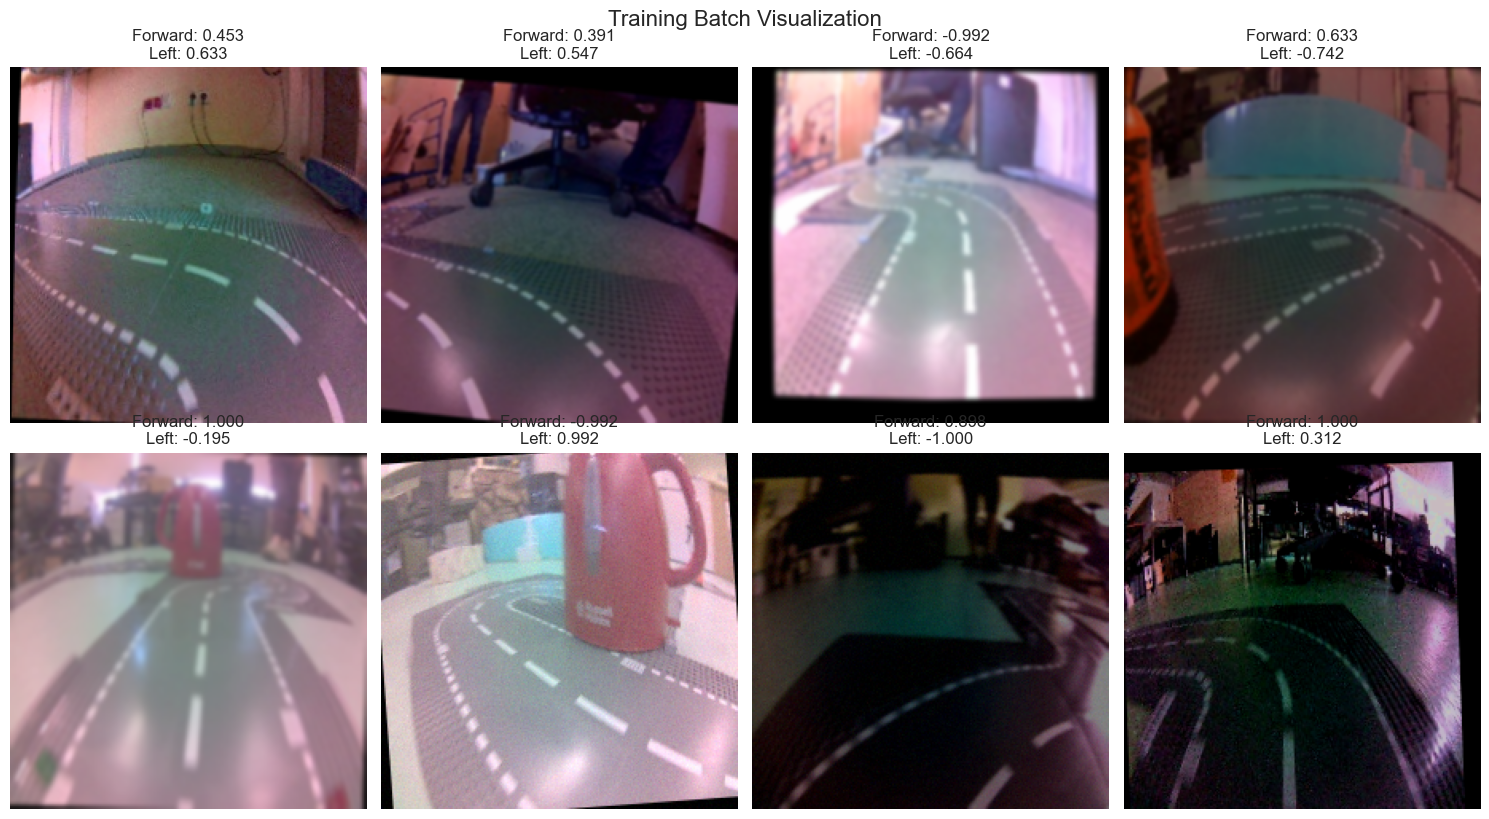

INFO:__main__:Model created with 436,100 parameters
c:\Users\mary9\anaconda3\envs\cv_lab\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
INFO:__main__:Starting training for 500 epochs...
INFO:__main__:Device: cpu
INFO:__main__:Model parameters: 436,100



=== Starting Training ===


INFO:__main__:Batch 0/2, Loss: 1.950765
INFO:__main__:Epoch 1/500 (0.7s) - Train Loss: 1.455953, Val Loss: 0.574508, Val MAE: 0.6623, Val R² (F/L): -0.860/-0.008, LR: 1.00e-03
INFO:__main__:Batch 0/2, Loss: 1.236456
INFO:__main__:Epoch 2/500 (0.6s) - Train Loss: 1.312741, Val Loss: 0.561600, Val MAE: 0.6496, Val R² (F/L): -0.788/-0.015, LR: 1.00e-03
INFO:__main__:Batch 0/2, Loss: 1.369332
INFO:__main__:Epoch 3/500 (0.6s) - Train Loss: 1.085372, Val Loss: 0.643076, Val MAE: 0.7021, Val R² (F/L): -1.194/-0.021, LR: 1.00e-03
INFO:__main__:Batch 0/2, Loss: 0.704664
INFO:__main__:Epoch 4/500 (0.6s) - Train Loss: 0.804551, Val Loss: 0.600182, Val MAE: 0.6756, Val R² (F/L): -0.974/-0.024, LR: 1.00e-03
INFO:__main__:Batch 0/2, Loss: 0.582635
INFO:__main__:Epoch 5/500 (0.6s) - Train Loss: 0.712580, Val Loss: 0.575938, Val MAE: 0.6572, Val R² (F/L): -0.840/-0.035, LR: 1.00e-03
INFO:__main__:Batch 0/2, Loss: 0.985000
INFO:__main__:Epoch 6/500 (0.6s) - Train Loss: 0.844097, Val Loss: 0.567407, Val


=== Plotting Training Curves ===


INFO:__main__:Training curves saved to training_curves.png


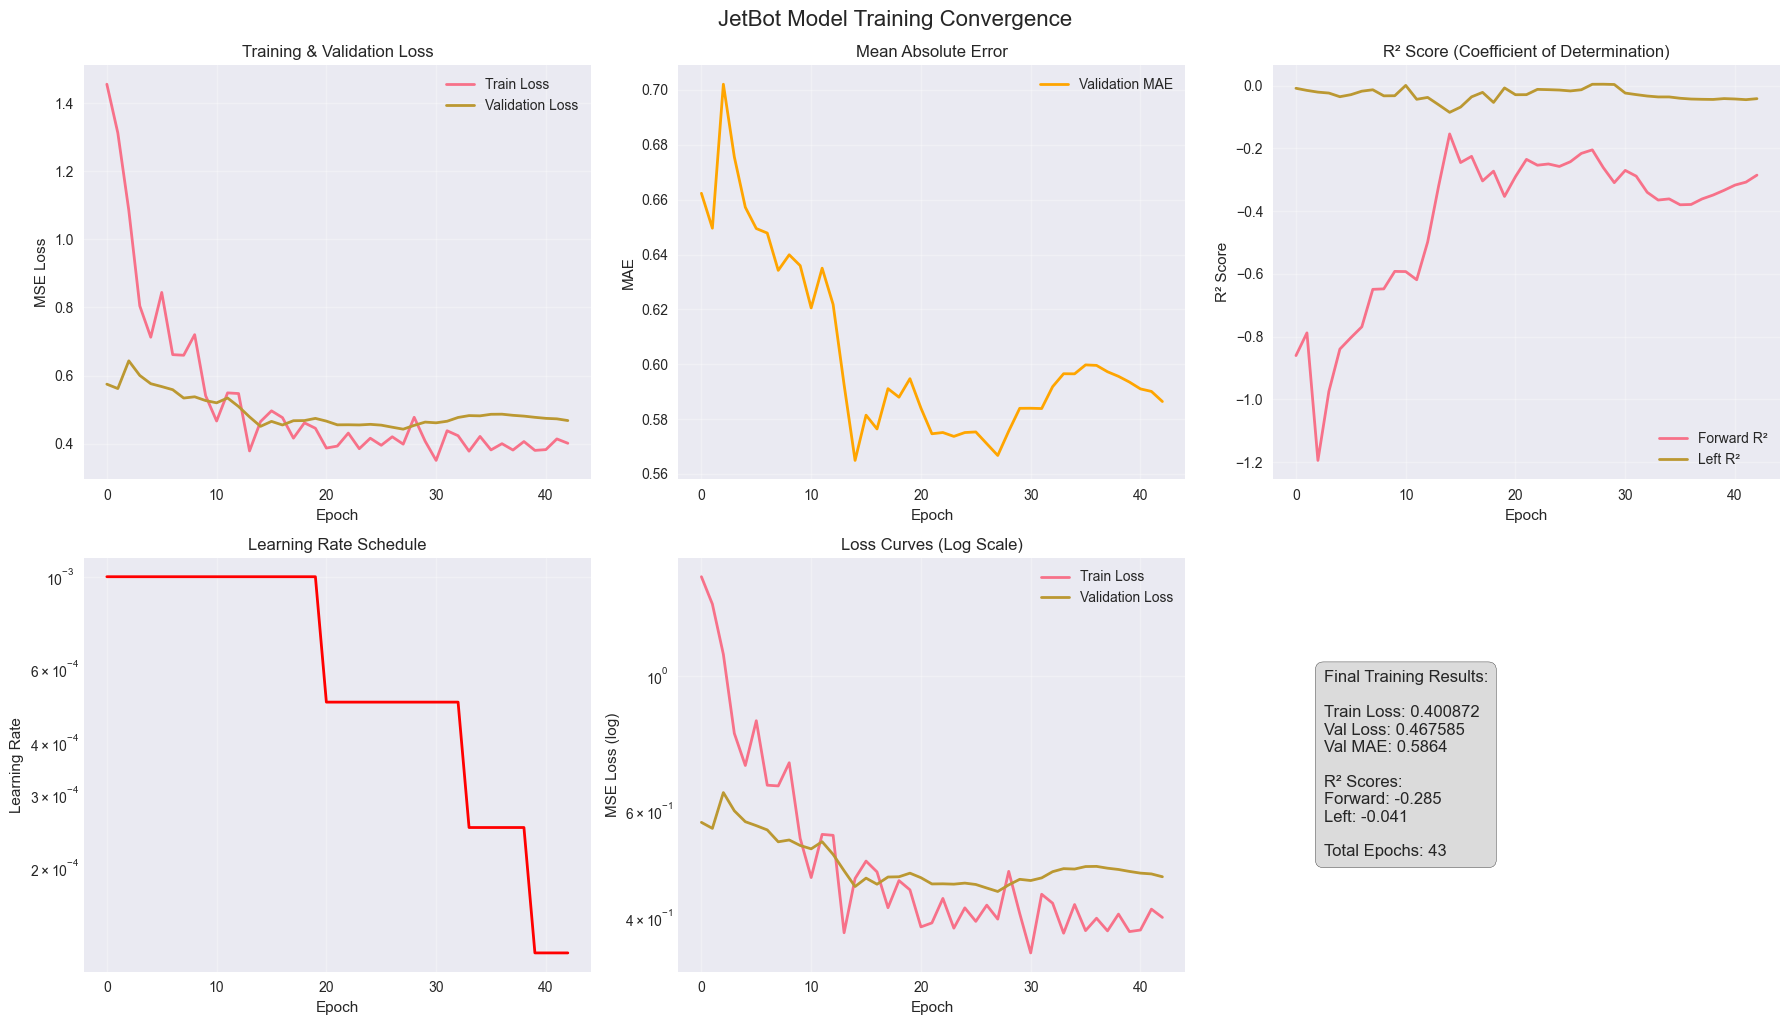

C:\Users\mary9\AppData\Local\Temp\ipykernel_33824\915618498.py:62: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('best_jetbot_model.pth', map_locatio


=== Final Model Evaluation ===


INFO:__main__:Evaluation plots saved to evaluation_results_evaluation.png


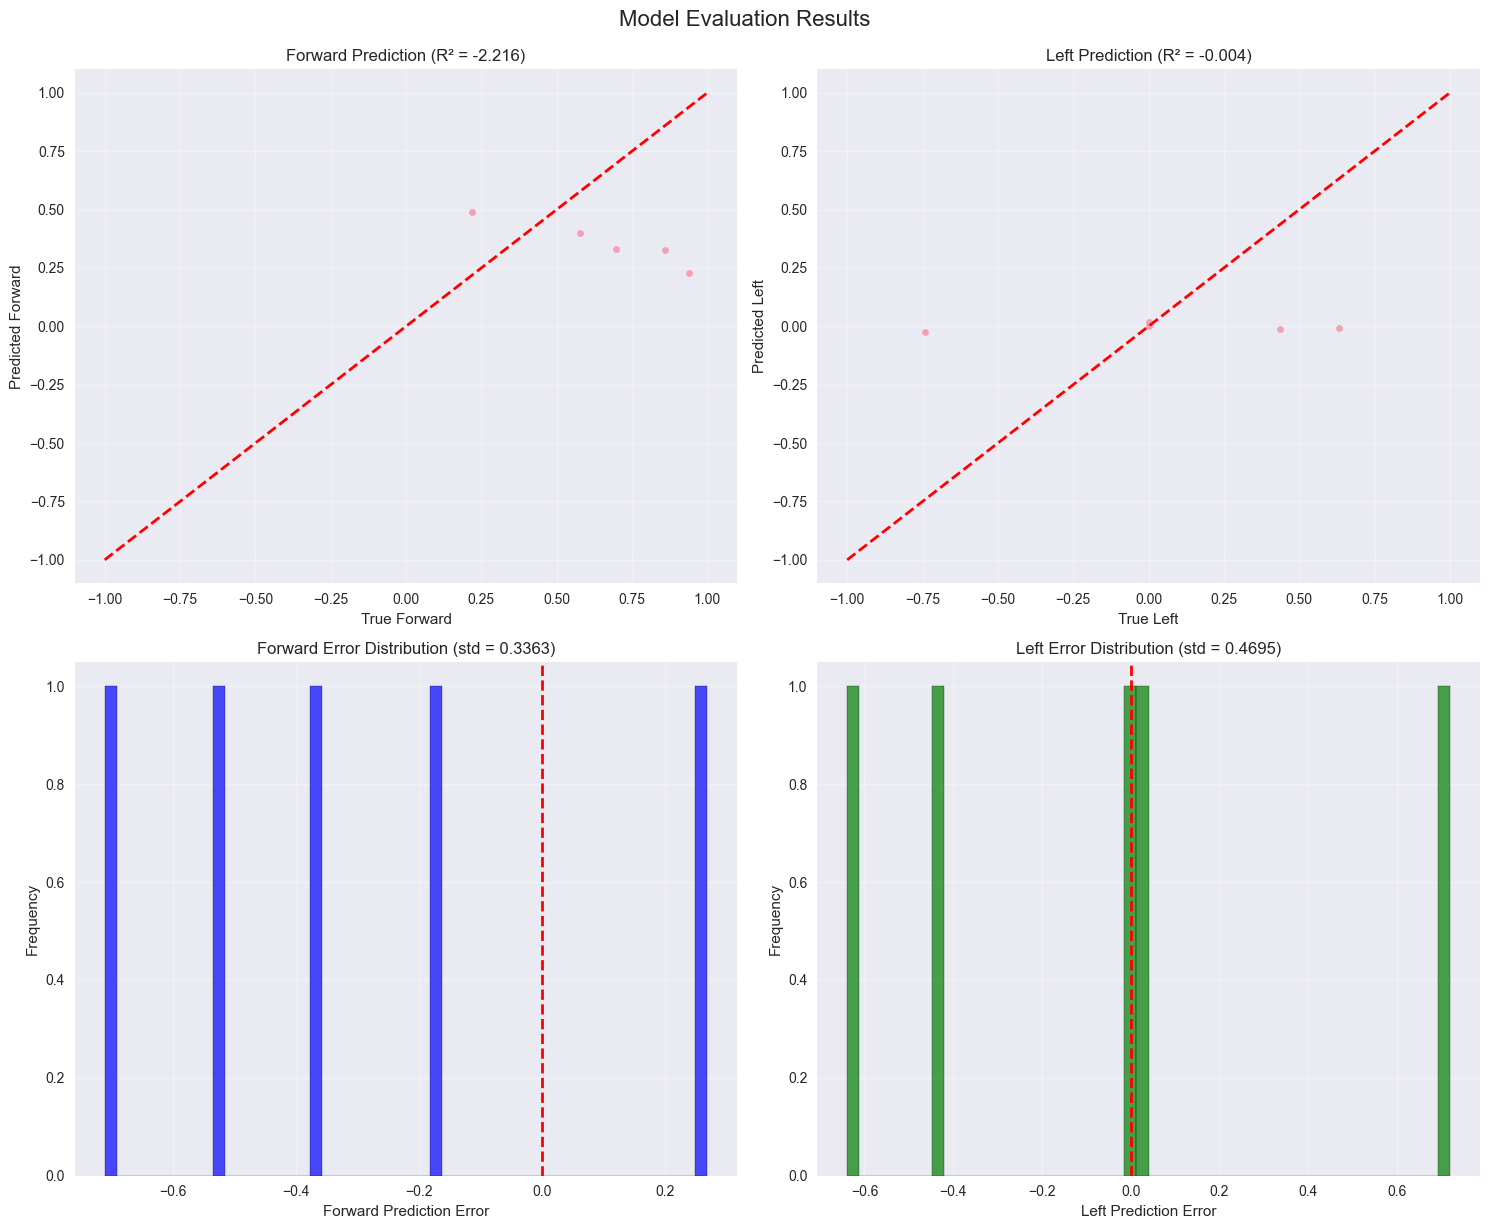

INFO:__main__:============================================================
INFO:__main__:FINAL MODEL EVALUATION RESULTS
INFO:__main__:============================================================
INFO:__main__:Overall Metrics:
INFO:__main__:  MSE:  0.215303
INFO:__main__:  MAE:  0.3884
INFO:__main__:  RMSE: 0.4640
INFO:__main__:
INFO:__main__:Forward Control Prediction:
INFO:__main__:  MSE: 0.205411
INFO:__main__:  MAE: 0.4113
INFO:__main__:  R²:  -2.216
INFO:__main__:  Error Std: 0.3363
INFO:__main__:
INFO:__main__:Left Control Prediction:
INFO:__main__:  MSE: 0.225196
INFO:__main__:  MAE: 0.3654
INFO:__main__:  R²:  -0.004
INFO:__main__:  Error Std: 0.4695
INFO:__main__:============================================================



=== Model Architecture Summary ===
Model: JetBotNet
Total parameters: 436,100
Trainable parameters: 436,100

=== Training Summary ===
Final training loss: 0.400872
Final validation loss: 0.467585
Best validation loss: 0.442271
Total epochs: 43


In [41]:
if __name__ == "__main__":
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    logger.info(f"Using device: {device}")
    
    try:
        # Create dataloaders
        train_loader, val_loader, test_loader = create_dataloaders(
            root_dir="../put_jetbot_dataset/dataset/",
            batch_size=16,
            train_split=0.7,
            val_split=0.2,
            test_split=0.1,
            use_albumentations=True,  # Start simple
            validate_data=True,
            balance_classes=True,
            num_workers=0,
            include_test=True
        )
        
        logger.info(f"Data loaded: {len(train_loader)} train, {len(val_loader)} val, {len(test_loader)} test batches")
        
        # Visualize training batch
        print("\n=== Visualizing Training Data ===")
        visualize_batch(train_loader, num_samples=8, save_path="training_batch_viz.png")
        
        # Create model
        model = JetBotNet(
            input_size=(224, 224),
            dropout_rate=0.3,
            use_batch_norm=True
        )
        
        logger.info(f"Model created with {sum(p.numel() for p in model.parameters()):,} parameters")
        
        # Create trainer
        trainer = JetBotTrainer(
            model=model,
            device=device,
            learning_rate=1e-3,
            weight_decay=1e-4,
            scheduler_patience=5,
            scheduler_factor=0.5
        )
        
        # Train model
        print("\n=== Starting Training ===")
        history = trainer.train(
            train_loader=train_loader,
            val_loader=val_loader,
            epochs=500,
            early_stopping_patience=15,
            save_best_model=True,
            model_save_path='best_jetbot_model.pth'
        )
        
        # Plot training curves
        print("\n=== Plotting Training Curves ===")
        plot_training_curves(history, save_path="training_curves.png")
        
        # Load best model for evaluation
        checkpoint = torch.load('best_jetbot_model.pth', map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        
        # Final evaluation
        print("\n=== Final Model Evaluation ===")
        evaluation_metrics = evaluate_model(
            model=model,
            test_loader=test_loader,
            device=device,
            save_path="evaluation_results.png"
        )
        
        # Model summary
        print(f"\n=== Model Architecture Summary ===")
        print(f"Model: {model.__class__.__name__}")
        print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")
        print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
        
        # Training summary
        print(f"\n=== Training Summary ===")
        print(f"Final training loss: {history['train_loss'][-1]:.6f}")
        print(f"Final validation loss: {history['val_loss'][-1]:.6f}")
        print(f"Best validation loss: {min(history['val_loss']):.6f}")
        print(f"Total epochs: {len(history['train_loss'])}")
        
    except Exception as e:
        logger.error(f"Error in training pipeline: {e}")
        import traceback
        traceback.print_exc()